# Training Inverted Pendulum using REINFORCE for Mujoco

from: https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/

In [2]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from   torch.distributions.normal import Normal

import gymnasium as gym

plt.rcParams["figure.figsize"] = (10, 5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("currently using: {}".format(device))

currently using: cuda


## Policy Network

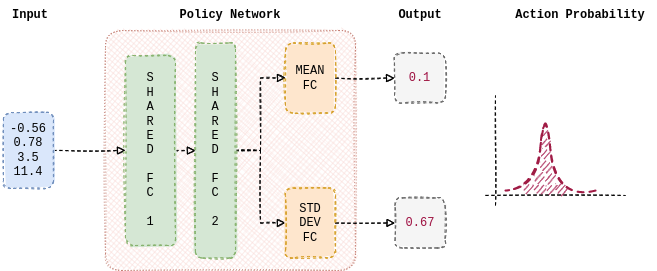


`action`: 1D [-3,3] = Force applied to cart

 A policy is a mapping from the current environment observation to a probability distribution of the actions to be taken.


In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, obs_space_dims: int, action_space_dims: int):

        super().__init__()

        hidden_layer1 = 16
        hidden_layer2 = 32

        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_layer1),
            nn.Tanh(),
            nn.Linear(hidden_layer1, hidden_layer2),
            nn.Tanh(),
        )

        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_layer2, action_space_dims)
        )

        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_layer2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:

        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        # action_stddev = self.policy_stddev_net(shared_features)
        
        action_stddev = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddev

    


## Agent

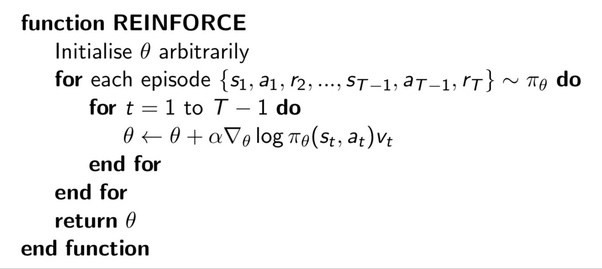

REINFROCE is an acronym for “ ‘RE’ward ‘I’ncrement ‘N’on-negative ‘F’actor times ‘O’ffset ‘R’einforcement times ‘C’haracteristic ‘E’ligibility

In [4]:
class REINFORCE:

    def __init__(self, obs_space_dims:int, action_space_dims:int):
        self.learning_rate = 1e-4
        self.gamma = 0.99
        self.eps = 1e-6

        self.probs=[]
        self.rewards=[]

        self.net = PolicyNetwork(obs_space_dims, action_space_dims)
        self.net = self.net.to(device)

        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        state = torch.tensor(np.array([state]))
        state = state.to(device)
        action_means, action_stddevs = self.net(state)

        distrib = Normal(action_means[0]+self.eps, action_stddevs[0]+self.eps)
        action  = distrib.sample()
        prob    = distrib.log_prob(action)


        action  = action.cpu().numpy()#.to(device)
        self.probs.append(prob)
        
        return action 
    
    def update(self):
        running_g = 0
        gs = []

        for R in self.rewards[::-1]:
            running_g = R + self.gamma*running_g
            gs.insert(0, running_g)


        deltas = torch.tensor(gs)

        loss = 0
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.probs = []
        self.rewards = []


## Training Policy

```
    for seed in random seeds
        reinitialize agent
        for episode in range of max number of episodes
            until episode is done
                sample action based on current observation
                take action and receive reward and next observation
                store action take, its probability, and the observed reward
            update the policy
```


In [6]:
env = gym.make("InvertedPendulum-v4", render_mode='human')
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(5e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []



for seed in [1, 2, 3, 5, 8]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)

            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)


rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()


Episode: 0 Average Reward: 7
